# Model Test
Uses a pre-trained model to make predictions for dates that occur after the last date included in the training data.

In [247]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### SET PARAMETERS:

In [586]:
import utils.text_utils as tu

MODEL_NAME= f"2024-05-22-1808-TDOC-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight23304-prec9935pct-fp6tp918-high_prec.pth"

TICKER= tu.extract_company(MODEL_NAME)
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False

DAYS_PREDICT = tu.extract_days(MODEL_NAME)
DOWN_PCTS_PREDICT= tu.extract_pcts(MODEL_NAME, "down")
UP_PCTS_PREDICT= tu.extract_pcts(MODEL_NAME, "up")

PREDICT_UP = tu.is_predict_up(MODEL_NAME)
if PREDICT_UP:
    INDEX_KEEP= 2
    INDEX_REMOVE_A= 0
    INDEX_REMOVE_B= 1
else:
    INDEX_KEEP= 0
    INDEX_REMOVE_A= 1
    INDEX_REMOVE_B= 2

signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]

HIDDEN_UNITS=12



# Load training data (!!!ONLY TO VERIFY):
Use to verify results: compare with results obtain when training
If don't need to verify training data Skip to step that load test data

In [510]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

### TRAINING DATA
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)

Retrieving TDOC from 2019-01-01 00:00:00 to 2020-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2019-01-01&endDate=2020-01-01&resampleFreq=15min&afterHours=false&format=csv


Retrieving TDOC from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2021-01-01&endDate=2022-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2022-01-01 00:00:00 to 2023-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2022-01-01&endDate=2023-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2023-01-01 00:00:00 to 2024-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2023-01-01&endDate=2024-01-01&resampleFreq=15min&afterHours=false&format=csv


In [ ]:
import io
import pandas as pd

# ### TRAINING DATA
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

if not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

## LOADING TEST DATA

In [512]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

# # For first prediction need signal_avg[-1]=2584 ticks -> 2584 / 26 ~ 100 days -> 100 * 7 / 5 / 30 = 4.6 months
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 8, 1), datetime(2023,12,31), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,5,25), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)


Retrieving TDOC from 2023-08-01 00:00:00 to 2023-12-31 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2023-08-01&endDate=2023-12-31&resampleFreq=15min&afterHours=false&format=csv


Retrieving TDOC from 2024-01-01 00:00:00 to 2024-05-25 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2024-01-01&endDate=2024-05-25&resampleFreq=15min&afterHours=false&format=csv


In [513]:
import io
import pandas as pd

### TEST PREDICTIONS ON RECENT DATA
df2023 = pd.read_csv(io.StringIO(csv_data2023))
df2024 = pd.read_csv(io.StringIO(csv_data2024))
df = pd.concat([df2023, df2024], axis=0, ignore_index=True)


In [514]:
# Validates that data has been concatenated correctly = ordered ascending
if df["date"].is_monotonic_increasing and df["date"].is_unique:
    print("Correct: DataFrame is in ascending order.")
else:
    print("Error: DataFrame is not in ascending order.")


Correct: DataFrame is in ascending order.


In [515]:
# Verify expected dates correspond with the data you intend to use
print(f"Test data first:\n{df[['date', 'close']][:5]}")
print(f"Test data last:\n{df[['date', 'close']][-5:]}")

Test data first:
                        date   close
0  2023-08-01 09:30:00-04:00  28.370
1  2023-08-01 09:45:00-04:00  28.250
2  2023-08-01 10:00:00-04:00  27.920
3  2023-08-01 10:15:00-04:00  27.825
4  2023-08-01 10:30:00-04:00  27.905
Test data last:
                           date   close
5455  2024-05-21 14:45:00-04:00  11.900
5456  2024-05-21 15:00:00-04:00  11.860
5457  2024-05-21 15:15:00-04:00  11.865
5458  2024-05-21 15:30:00-04:00  11.845
5459  2024-05-21 15:45:00-04:00  11.825


In [587]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT
REACH_PCT= 0.95

import classifiers.up_down_classifier as udc
import classifiers.ewa_classifier as ec

alpha= ec.calculate_ewa_alpha(TICKS_PREDICT, REACH_PCT)
print(f"alpha: {alpha:.4f} for window: {TICKS_PREDICT} and reach: {REACH_PCT}")

classes_calc = udc.UpsDownsClassifier(TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

close_prices = df['close'].astype(float).tolist()
input_data= ec.calculate_ewas(close_prices, alpha)

classes= classes_calc.classify(input_data)
print(f"Check correct 'nan' point (window={TICKS_PREDICT}): {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
print(f"prices vs input_data: {[(p, c) for p, c in zip(close_prices[2650:3000], input_data[2650:3000])]}")
print(f"input_data vs classes: {[(p, c) for p, c in zip(input_data[2650:3000], classes[2650:3000])]}")


alpha: 0.0377 for window: 78 and reach: 0.95
Check correct 'nan' point (window=78): [0, nan]
prices vs input_data: [(20.65, 21.17787171641331), (20.495, 21.152142042804385), (20.91, 21.143018461348884), (20.93, 21.134992216665665), (20.995, 21.129717501142938), (20.91, 21.12143884578982), (20.965, 21.115544443744483), (21.045, 21.112886425453723), (21.045, 21.11032855766184), (21.075, 21.108997425860853), (21.185, 21.111861099050174), (21.105, 21.111602582208842), (21.015, 21.10796272885093), (20.995, 21.103706447512213), (21.05, 21.101682861922168), (21.01, 21.098228376905304), (20.985, 21.09396208631072), (21.045, 21.092117261770905), (21.045, 21.09034194770009), (21.185, 21.093908533826873), (21.16, 21.096398770004615), (21.19, 21.099925536510373), (21.17, 21.102565846587026), (21.155, 21.10454149387311), (21.18, 21.10738466732282), (21.255, 21.112946611445214), (21.25, 21.11811059593857), (21.285, 21.12439876074622), (21.58, 21.141565193181574), (21.46, 21.15356338178454), (21.38, 

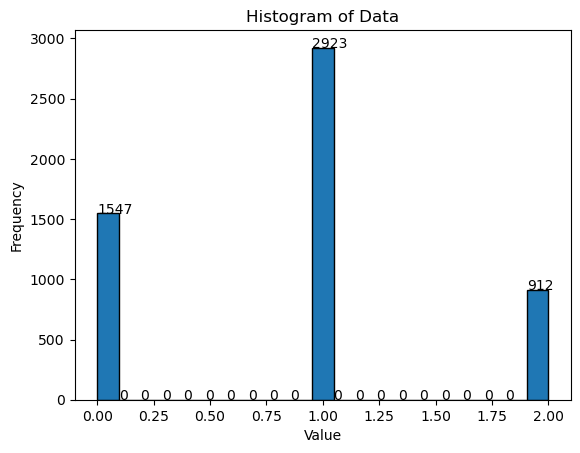

In [588]:
# Display histogram for the classes

import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=21, edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(edge, value, str(int(value)), color='black')
    
plt.show()

In [589]:
# Show percentages of each class value
import utils.list_utils as lu

lu.display_frequency_classes(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 5460
 28.33%   1547 times -3.0% change (0)
 53.53%   2923 times   0% change (1)
 16.70%    912 times 3.0% change (2)
  1.43%     78 times   0% change (nan)


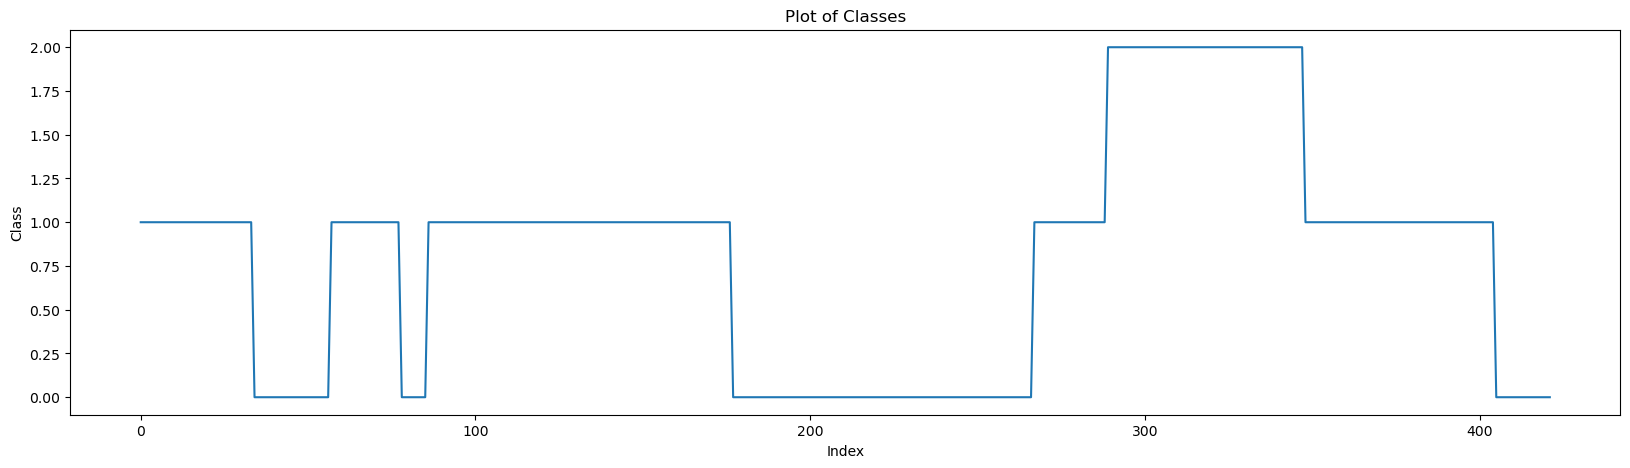

In [590]:

# Display classes value changes over time (last 500 ticks)
graph_ticks = 500
x = range(len(classes[-graph_ticks:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-graph_ticks:], linestyle='-')

plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

plt.show()

In [591]:

# Calculate the signals as input for the neural network as proportions
import preprocessing.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_prices)


In [592]:
print(f"Prices length: {len(close_prices)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_prices[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Length: {len(signal_avg)} Last: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "nan" 
print(f"Classes last non-nan: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-nan(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 5460
Proportions length: 5460
Last 10 close: [11.885, 11.9, 11.94, 11.93, 11.93, 11.9, 11.86, 11.865, 11.845, 11.825]
Last 10 proportions(avg=2): [-0.00168279343711094, 0.0006302521008351355, 0.0016750418760416584, -0.0004191114836599291, -5.360339163320119e-15, -0.0012605042016859446, -0.0016863406408147996, 0.00021070375052147745, -0.0008442380751425694, -0.0008456659619505719]
Proportions avgs: Length: 16 Last: 2584
Classes last non-nan: [0, nan] len: 5460
Proportions first non-nan(avg=2584): [nan, 0.016903305393179437] len: 5460
Proportions (avg=2) Min: -0.13699906803355466 Max: 0.035532994923858335
Proportions (avg=2584) Min: -0.43129877332722494 Max: 0.12997767570157948


In [593]:
# Removing the "nan" from the proportions
#   At the beging first signal_avg[-1] are "nan" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[0.0020899926235558165, 0.0018373346398826542]
[0.002130972871077173, 0.0038379879144218964]
[0.0023604622571867066, 0.004605585497299905]
[-0.00024588148512202473, 0.004134002939737582]
[-0.004501522573812474, -0.000508800361814333]
[-0.005760651937193897, -0.0016098551130389591]
[-0.010008822806230732, -0.005879470847623589]
[-0.023716386883339106, -0.01884993986904688]
[0.0008619665545941897, 0.003798534536387632]
[0.0265500778624706, 0.02973419892209747]
[0.040522957205010424, 0.04362394938103339]
[0.061138398665852516, 0.06417447628652824]
[0.09665843030872166, 0.09970763287041802]
[0.13248378415342668, 0.13552766066657082]
[0.11347207289793393, 0.11669540849651766]
[0.016903305393179437, 0.020666791304573294]
First target: 2 and last target: 0
Classes: 5460 after cut to targets: 2799
Inputs len: 2799
Distinct targets: [0, 1, 2]


In [594]:
from collections import Counter

print("Test data: 'nan' removed from begining and end")
lu.display_frequency_classes(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[INDEX_REMOVE_A] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
count_remove_b= targets_frequency[INDEX_REMOVE_B] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
print(f"Removing {INDEX_REMOVE_A}: {count_remove_a}")
print(f"Removing {INDEX_REMOVE_B}: {count_remove_b}")


Test data: 'nan' removed from begining and end
Total: 2799
 27.12%    759 times -3.0% change (0)
 58.16%   1628 times   0% change (1)
 14.72%    412 times 3.0% change (2)
VALIDATE removing should be POSITIVE?
Removing 1: 1248
Removing 2: 32


In [595]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={INDEX_KEEP})(First:{targets_clean.index(INDEX_KEEP)},Last:-{targets_clean[::-1].index(INDEX_KEEP)})")


Total: 2799
 27.12%    759 times -3.0% change (0)
 58.16%   1628 times   0% change (1)
 14.72%    412 times 3.0% change (2)
Targets len: 2799 Targets clean: 2799 Difference: 0
targets_clean positions(Keep=0)(First:386,Last:-0)


In [596]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, INDEX_KEEP)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 386 and Last(counting from end) 0 position with True
targets_binary len: 2799 Input clean[0]: 2799 Input clean[-1]: 2799


In [597]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 2799])
inputs_tensor: torch.Size([2799, 16])
inputs_clean len0 x len1: 16 x 2799 -> inputs_tensor.shape: torch.Size([2799, 16])
targets_binary.shape: 2799 -> targets_tensor.shape: torch.Size([2799])
inputs_tensor: tensor([[ 2.0900e-03,  2.1310e-03,  2.3605e-03,  ...,  1.3248e-01,
          1.1347e-01,  1.6903e-02],
        [ 1.8373e-03,  3.8380e-03,  4.6056e-03,  ...,  1.3553e-01,
          1.1670e-01,  2.0667e-02],
        [ 1.1000e-03,  2.6888e-03,  5.2310e-03,  ...,  1.3729e-01,
          1.1860e-01,  2.2969e-02],
        ...,
        [-7.7912e-04, -7.7912e-04,  1.0129e-03,  ..., -6.1646e-02,
         -1.0436e-01, -2.9358e-01],
        [ 3.8926e-04, -5.5317e-16,  7.0066e-04,  ..., -6.0643e-02,
         -1.0338e-01, -2.9229e-01],
        [ 1.9387e-03,  2.8435e-03,  3.1020e-03,  ..., -5.6355e-02,
         -9.8982e-02, -2.8700e-01]])
targets_tensor: tensor([0., 0., 0.,  ..., 1., 1., 1.])


In [598]:

inputs_tensor_test, targets_tensor_test= inputs_tensor, targets_tensor

print("Test dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())



Test dataset frequencies:
Total: 2799
 72.88%   2040 times (0.0)
 27.12%    759 times (1.0)


In [599]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [600]:
from torch.utils.data import DataLoader

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"First input vector:\n{test_dataset[0]}")

test_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_input0, test_target0= next(iter(test_dataloader))
print(f"Dataloader batch={BATCH_SIZE}\nInput:\n{test_input0}\nTargets:\n{test_target0}")


First input vector:
(tensor([ 0.0021,  0.0021,  0.0024, -0.0002, -0.0045, -0.0058, -0.0100, -0.0237,
         0.0009,  0.0266,  0.0405,  0.0611,  0.0967,  0.1325,  0.1135,  0.0169]), tensor(0.))
Dataloader batch=32
Input:
tensor([[ 2.0900e-03,  2.1310e-03,  2.3605e-03, -2.4588e-04, -4.5015e-03,
         -5.7607e-03, -1.0009e-02, -2.3716e-02,  8.6197e-04,  2.6550e-02,
          4.0523e-02,  6.1138e-02,  9.6658e-02,  1.3248e-01,  1.1347e-01,
          1.6903e-02],
        [ 1.8373e-03,  3.8380e-03,  4.6056e-03,  4.1340e-03, -5.0880e-04,
         -1.6099e-03, -5.8795e-03, -1.8850e-02,  3.7985e-03,  2.9734e-02,
          4.3624e-02,  6.4174e-02,  9.9708e-02,  1.3553e-01,  1.1670e-01,
          2.0667e-02],
        [ 1.1000e-03,  2.6888e-03,  5.2310e-03,  5.8665e-03,  1.9931e-03,
          6.8676e-04, -3.1849e-03, -1.5502e-02,  5.0893e-03,  3.1468e-02,
          4.5277e-02,  6.5813e-02,  1.0141e-01,  1.3729e-01,  1.1860e-01,
          2.2969e-02],
        [ 2.7953e-03,  4.4563e-03,  8.0700e

In [601]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [602]:
# Loads model from file
from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_0.to(device)

print(f"Test model loaded: {MODEL_NAME}")

Test model loaded: 2024-05-22-1808-TDOC-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight23304-prec9935pct-fp6tp918-high_prec.pth


In [603]:
TEST_THRESHOLD = 0.9999999

Test threshold: 0.9999999
Test confusion matrix:
tensor([[1775,  265],
        [ 614,  145]])
Test Accuracy: 68.60%
Test Precision: 35.37%
Test false_positives: 265 true_positives: 145


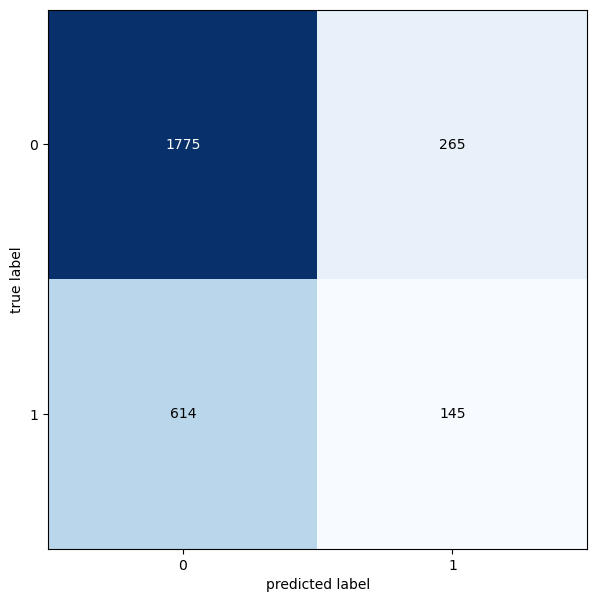

In [604]:
from torchmetrics import ConfusionMatrix, Accuracy, Precision
from mlxtend.plotting import plot_confusion_matrix

model_0.eval()
test_precision= 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for test data
    test_logits= model_0(X).view(-1)
    sigmoid_output = torch.sigmoid(test_logits)
    test_pred = (sigmoid_output > TEST_THRESHOLD).float()    

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= test_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

accuracy_fn= Accuracy(task='binary').to(device)
test_accuracy = accuracy_fn(test_pred, y)
print(f"Test threshold: {TEST_THRESHOLD}")
print(f"Test confusion matrix:\n{confmat_tensor}")

precision_fn= Precision(task='binary').to(device)
test_precision = precision_fn(test_pred, y)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"Test false_positives: {false_positives} true_positives: {true_positives}")

In [605]:
# Example of threshold adjustment after model training
from sklearn.metrics import precision_recall_curve
import numpy as np

model_0.eval()
with torch.no_grad():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    logits = model_0(X)
    probs = torch.sigmoid(logits).cpu().numpy()
    y_cpu = y.cpu().numpy()
    
precision, recall, thresholds = precision_recall_curve(y_cpu, probs)

# Find the threshold that gives the highest precision
optimal_idx = np.argmax(precision[:-1])
optimal_threshold = thresholds[optimal_idx]
print("optimal_threshold: ", optimal_threshold)

optimal_threshold:  0.99999976


#### Summary

In [606]:
print("======TEST:")
print(f"Ticker: {TICKER}")

print(f"Data start: {df['date'][0]} end: {df['date'].iloc[-1]}")
print(f"Data Interval: {DATA_INTERVAL_MINUTES} - After Hours: {DATA_AFTER_HOURS}")

print(f"Signal Averages: {signal_avg}")
print(f"Predict {'UP' if PREDICT_UP else 'DOWN'} - days: {DAYS_PREDICT} Down pcts: {DOWN_PCTS_PREDICT} Up pcts: {UP_PCTS_PREDICT}")
print("Targets Frequencies:")
lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

print("Test dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())

print("--Inference")
print(f"Network hidden units: {HIDDEN_UNITS}")
print(f"== Test threshold: {TEST_THRESHOLD}")

print("--Inference Results")
print(f"Trained model: {MODEL_NAME}")
print(f"Test confusion matrix:\n{confmat_tensor}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test precision: {test_precision*100:.2f}%")
print(f"Test false_positives: {false_positives} true_positives: {true_positives}")


======TEST:
Ticker: TDOC
Data start: 2023-08-01 09:30:00-04:00 end: 2024-05-21 15:45:00-04:00
Data Interval: 15 - After Hours: False
Signal Averages: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
Predict DOWN - days: 3 Down pcts: [3.0] Up pcts: [3.0]
Targets Frequencies:
Total: 2799
 27.12%    759 times -3.0% change (0)
 58.16%   1628 times   0% change (1)
 14.72%    412 times 3.0% change (2)
Test dataset frequencies:
Total: 2799
 72.88%   2040 times (0.0)
 27.12%    759 times (1.0)
--Inference
Network hidden units: 12
== Test threshold: 0.9999999
--Inference Results
Trained model: 2024-05-22-1808-TDOC-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight23304-prec9935pct-fp6tp918-high_prec.pth
Test confusion matrix:
tensor([[1775,  265],
        [ 614,  145]])
Test accuracy: 68.60%
Test precision: 35.37%
Test false_positives: 265 true_positives: 145
